In [2]:
import pandas as pd


# 1. 读取数据
file_path = r"C:\Users\nawat\Desktop\CS\dataset\D1_sensor_data.csv"
df = pd.read_csv(file_path)

# 2. 解析时间戳为 datetime 并排序
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
df = df.sort_values('published_at')

# 3. 类型转换 + 提取需要的列 + 筛选 tag_number = 202204
cols = ['published_at', 'temperature', 'humidity', 'hive_power', 'tag_number']
df = df[cols]
df[['temperature', 'humidity', 'hive_power', 'tag_number']] = df[['temperature', 'humidity', 'hive_power', 'tag_number']].apply(pd.to_numeric, errors='coerce')
df = df[df['tag_number'] == 202204]

# 4. 去重 + 去除缺失值
df = df.drop_duplicates(subset='published_at')
df = df.dropna(subset=['temperature', 'humidity', 'hive_power'])

# 5. 设置时间为索引并重采样为小时级平均
df = df.set_index('published_at').sort_index()
df_hourly = df.resample('1h').mean()

# 6. 添加月份变量列（格式为 YYYY-MM）
df_hourly = df_hourly.reset_index()
df_hourly['month'] = df_hourly['published_at'].dt.to_period('M').astype(str)

# ✅ 输出结果预览（可选）
print(df_hourly.head())


               published_at  temperature  humidity  hive_power  tag_number  \
0 2020-05-26 10:00:00+00:00       28.980   44.9700      -8.593    202204.0   
1 2020-05-26 11:00:00+00:00       33.560   55.2000       4.590    202204.0   
2 2020-05-26 12:00:00+00:00          NaN       NaN         NaN         NaN   
3 2020-05-26 13:00:00+00:00          NaN       NaN         NaN         NaN   
4 2020-05-26 14:00:00+00:00       36.145   52.2725       1.104    202204.0   

     month  
0  2020-05  
1  2020-05  
2  2020-05  
3  2020-05  
4  2020-05  


C:\Users\nawat\AppData\Local\Temp\ipykernel_14448\3371301642.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_hourly['month'] = df_hourly['published_at'].dt.to_period('M').astype(str)


In [3]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
df_hourly_clean['month'].value_counts()


month
2020-09    719
2020-08    701
2020-07    680
2020-06    637
2020-10    444
2020-11     21
2020-05      7
Name: count, dtype: int64

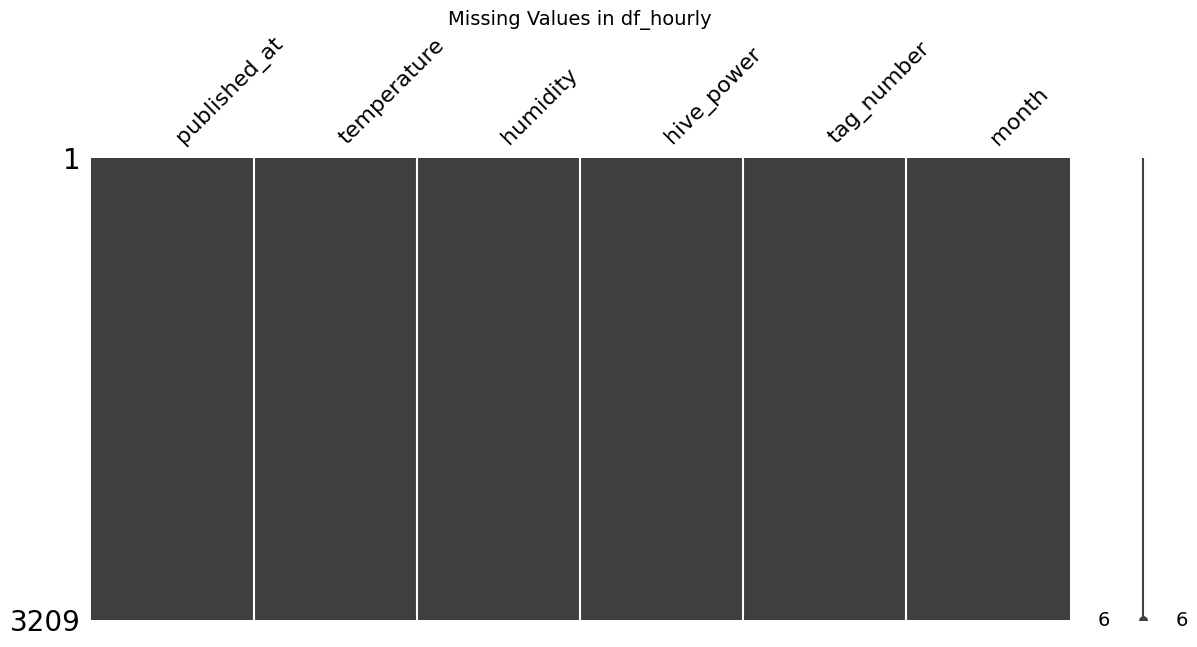

In [4]:
import missingno as msno
import matplotlib.pyplot as plt
df_hourly_clean = df_hourly.dropna(subset=['temperature', 'humidity', 'hive_power'])
# 假设 df_hourly 是你当前包含缺失值的 DataFrame
msno.matrix(df_hourly_clean, figsize=(14, 6), sparkline=True)
plt.title("Missing Values in df_hourly", fontsize=14)
plt.show()



In [5]:
pip install PyIF

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install nose

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from PyIF import te_compute as te
import numpy as np
import pandas as pd

# jitter 函数：给浮点数加非常小的噪声，避免重复值导致 TE 报错
def jitter(x, eps=1e-8):
    return x + np.random.normal(0, eps, size=len(x))

results = []

for month, group in df_hourly_clean.groupby("month"):
    # 显式跳过数据稀少月份
    if month in ['2020-05', '2020-11']:
        print(f"[Skip] Skipping month {month} (too few records)")
        continue

    # 变量取值（加 jitter）
    temp = jitter(group['temperature'].values)
    humid = jitter(group['humidity'].values)
    power = jitter(group['hive_power'].values)

    # 长度判断
    if len(temp) < 20 or len(power) < 20 or len(humid) < 20:
        print(f"[Skip] {month} has too few rows even after jitter")
        continue

    try:
        te_tp = te.te_compute(temp, power, k=1, embedding=1, safetyCheck=True, GPU=False)
        te_pt = te.te_compute(power, temp, k=1, embedding=1, safetyCheck=True, GPU=False)
        te_hp = te.te_compute(humid, power, k=1, embedding=1, safetyCheck=True, GPU=False)
        te_ph = te.te_compute(power, humid, k=1, embedding=1, safetyCheck=True, GPU=False)

        if None in [te_tp, te_pt, te_hp, te_ph]:
            print(f"[Warning] TE returned None in {month}")
            continue

        dindex_tp = te_tp - te_pt
        dindex_hp = te_hp - te_ph

        results.append({
            "month": month,
            "TE_temp→power": te_tp,
            "TE_power→temp": te_pt,
            "DirIndex_temp→power": dindex_tp,
            "TE_humid→power": te_hp,
            "TE_power→humid": te_ph,
            "DirIndex_humid→power": dindex_hp
        })

    except Exception as e:
        print(f"[!] TE error in {month}: {e}")
        continue

# 转为 DataFrame
te_df = pd.DataFrame(results)
print(te_df)


C:\Users\nawat\AppData\Roaming\Python\Python310\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


[Skip] Skipping month 2020-05 (too few records)
[Skip] Skipping month 2020-11 (too few records)
     month  TE_temp→power  TE_power→temp  DirIndex_temp→power  TE_humid→power  \
0  2020-06      -0.093676       0.081727            -0.175402        0.109441   
1  2020-07      -0.098867      -0.042823            -0.056045        0.033772   
2  2020-08      -0.124063      -0.004133            -0.119930        0.012994   
3  2020-09       0.131219      -0.006155             0.137374        0.007392   
4  2020-10       0.140792       0.006762             0.134030        0.034244   

   TE_power→humid  DirIndex_humid→power  
0        0.083047              0.026394  
1       -0.058848              0.092620  
2        0.172656             -0.159661  
3        0.095803             -0.088411  
4        0.043707             -0.009463  


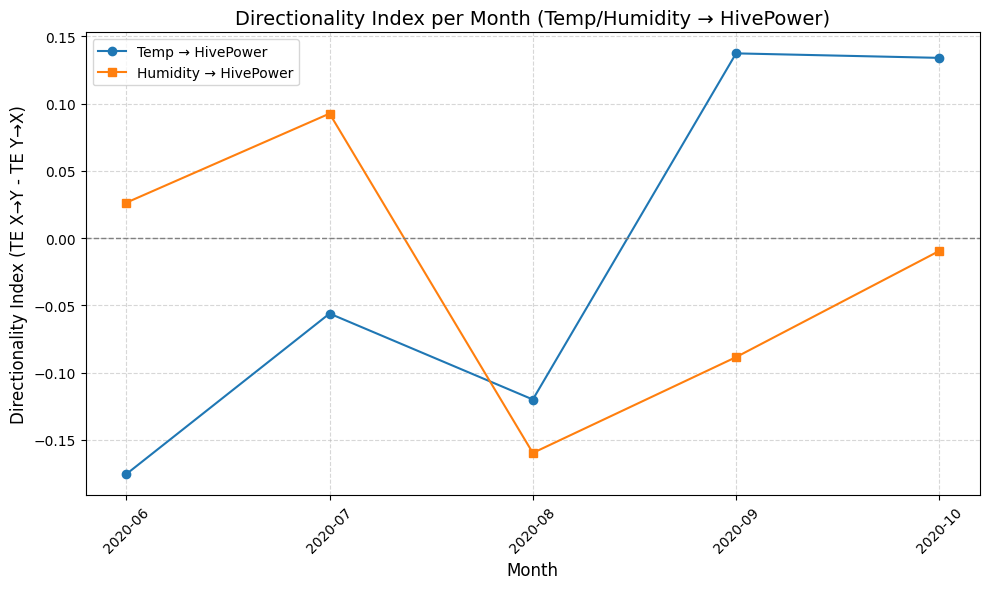

In [9]:
import matplotlib.pyplot as plt

# 确保月份按时间顺序排列
te_df_sorted = te_df.sort_values('month')

# 设置绘图
plt.figure(figsize=(10, 6))

# 画两条线：温度方向性、湿度方向性
plt.plot(te_df_sorted['month'], te_df_sorted['DirIndex_temp→power'], marker='o', label='Temp → HivePower')
plt.plot(te_df_sorted['month'], te_df_sorted['DirIndex_humid→power'], marker='s', label='Humidity → HivePower')

# 加横线标出0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# 美化图表
plt.title('Directionality Index per Month (Temp/Humidity → HivePower)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Directionality Index (TE X→Y - TE Y→X)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

# 展示图像
plt.show()


In [18]:
from PyIF import te_compute as te
import numpy as np
import pandas as pd

# 假设 df_hourly_clean 已经准备好并按小时采样，有 'month', 'temperature', 'hive_power'
def jitter(x, eps=1e-8):
    return x + np.random.normal(0, eps, size=len(x))

# 结果列表
surrogate_results = []

# 要测试的月份（可根据需要删减）
months_to_test = sorted(df_hourly_clean['month'].unique())

# 参数设置
n_surrogates = 100  # surrogate 数量
min_len = 20        # 最小数据长度

for month in months_to_test:
    if month in ['2020-05', '2020-11']:  # 可选跳过数据少的月份
        continue

    group = df_hourly_clean[df_hourly_clean['month'] == month].copy()

    # jitter 处理
    temp = jitter(group['temperature'].values)
    power = jitter(group['hive_power'].values)

    if len(temp) < min_len or len(power) < min_len:
        print(f"[Skip] {month} too short")
        continue

    try:
        # 实际 TE
        actual_te = te.te_compute(temp, power, k=1, embedding=1, safetyCheck=True, GPU=False)

        # surrogate 分布
        surrogate_tes = []
        for _ in range(n_surrogates):
            shuffled_temp = np.random.permutation(temp)
            te_surr = te.te_compute(shuffled_temp, power, k=1, embedding=1, safetyCheck=True, GPU=False)
            if te_surr is not None:
                surrogate_tes.append(te_surr)

        if len(surrogate_tes) > 0:
            p_val = np.sum(np.array(surrogate_tes) >= actual_te) / len(surrogate_tes)
        else:
            p_val = None

        surrogate_results.append({
            "month": month,
            "TE_temp→power": actual_te,
            "p_value": p_val
        })

    except Exception as e:
        print(f"[Error] {month}: {e}")
        continue

# 转为 DataFrame
df_surrogate = pd.DataFrame(surrogate_results)
print(df_surrogate)


     month  TE_temp→power  p_value
0  2020-06      -0.077698     0.88
1  2020-07      -0.099055     0.85
2  2020-08      -0.121769     0.95
3  2020-09       0.137959     0.10
4  2020-10       0.150305     0.12


In [19]:
from PyIF import te_compute as te
import numpy as np
import pandas as pd

# 假设 df_hourly_clean 已准备好，含 'month', 'humidity', 'hive_power'
def jitter(x, eps=1e-8):
    return x + np.random.normal(0, eps, size=len(x))

# 结果存储
surrogate_results_humid = []

months_to_test = sorted(df_hourly_clean['month'].unique())
n_surrogates = 100
min_len = 20

for month in months_to_test:
    if month in ['2020-05', '2020-11']:
        continue

    group = df_hourly_clean[df_hourly_clean['month'] == month].copy()

    humid = jitter(group['humidity'].values)
    power = jitter(group['hive_power'].values)

    if len(humid) < min_len or len(power) < min_len:
        print(f"[Skip] {month} too short")
        continue

    try:
        actual_te = te.te_compute(humid, power, k=1, embedding=1, safetyCheck=True, GPU=False)

        surrogate_tes = []
        for _ in range(n_surrogates):
            shuffled_humid = np.random.permutation(humid)
            te_surr = te.te_compute(shuffled_humid, power, k=1, embedding=1, safetyCheck=True, GPU=False)
            if te_surr is not None:
                surrogate_tes.append(te_surr)

        if len(surrogate_tes) > 0:
            p_val = np.sum(np.array(surrogate_tes) >= actual_te) / len(surrogate_tes)
        else:
            p_val = None

        surrogate_results_humid.append({
            "month": month,
            "TE_humid→power": actual_te,
            "p_value": p_val
        })

    except Exception as e:
        print(f"[Error] {month}: {e}")
        continue

# 生成 DataFrame 输出
df_surrogate_humid = pd.DataFrame(surrogate_results_humid)
print(df_surrogate_humid)


     month  TE_humid→power  p_value
0  2020-06        0.104871     0.09
1  2020-07        0.028398     0.40
2  2020-08        0.013782     0.51
3  2020-09        0.006512     0.48
4  2020-10        0.034606     0.40


In [10]:
import pandas as pd
import numpy as np
from pyinform.transferentropy import transfer_entropy
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt


In [11]:
# 假设你的 df_hourly_clean 是干净的、每小时采样、有 'month', 'temperature', 'hive_power', 'humidity'

# ===== STEP 1: 离散化连续变量为整数符号（5 分位等频） =====
def discretize_series(series, bins=5):
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    return est.fit_transform(series.values.reshape(-1, 1)).astype(int).flatten()

df_disc = df_hourly_clean.copy()
df_disc["temp_disc"] = discretize_series(df_disc["temperature"])
df_disc["humid_disc"] = discretize_series(df_disc["humidity"])
df_disc["power_disc"] = discretize_series(df_disc["hive_power"])

# ===== STEP 2: 计算每个月的 TE(lag) 并找出最大 lag =====
max_lag = 24  # 探索 1~24 小时的滞后
results = []

for month, group in df_disc.groupby("month"):
    x = group["temp_disc"].values
    y = group["power_disc"].values
    
    if len(x) <= max_lag + 1: continue  # 数据太短跳过

    best_te = -np.inf
    best_k = None
    te_by_k = []

    for k in range(1, max_lag + 1):
        x_lag = x[:-k]
        y_shift = y[k:]

        if len(np.unique(x_lag)) < 2 or len(np.unique(y_shift)) < 2:
            continue  # 恒定序列跳过

        try:
            te_val = transfer_entropy(x_lag, y_shift, k=1)
            te_by_k.append((k, te_val))
            if te_val > best_te:
                best_te = te_val
                best_k = k
        except:
            continue

    if best_k is not None:
        results.append({
            "month": month,
            "best_lag_hours": best_k,
            "max_TE": best_te
        })

# 转为 DataFrame
df_cts = pd.DataFrame(results)
print(df_cts)


     month  best_lag_hours    max_TE
0  2020-06              20  0.091447
1  2020-07               6  0.053804
2  2020-08              20  0.099630
3  2020-09               3  0.061664


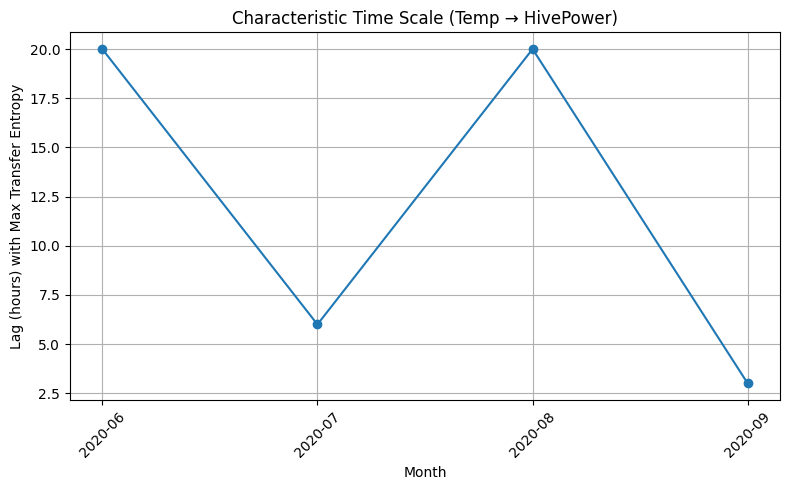

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(df_cts["month"], df_cts["best_lag_hours"], marker='o')
plt.title("Characteristic Time Scale (Temp → HivePower)")
plt.xlabel("Month")
plt.ylabel("Lag (hours) with Max Transfer Entropy")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from pyinform.transferentropy import transfer_entropy
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt

# 假设你已有 df_hourly_clean 是干净的每小时数据，含 "humidity" 和 "hive_power"

# Step 1: 离散化
def discretize_series(series, bins=5):
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    return est.fit_transform(series.values.reshape(-1, 1)).astype(int).flatten()

df_disc = df_hourly_clean.copy()
df_disc["humid_disc"] = discretize_series(df_disc["humidity"])
df_disc["power_disc"] = discretize_series(df_disc["hive_power"])

# Step 2: Characteristic Time Scale 计算（湿度 → hive_power）
max_lag = 24  # 最多滞后 24 小时
results_humid = []

for month, group in df_disc.groupby("month"):
    x = group["humid_disc"].values      # 湿度是 source
    y = group["power_disc"].values      # hive_power 是 target
    
    if len(x) <= max_lag + 1: continue

    best_te = -np.inf
    best_k = None

    for k in range(1, max_lag + 1):
        x_lag = x[:-k]
        y_shift = y[k:]

        if len(np.unique(x_lag)) < 2 or len(np.unique(y_shift)) < 2:
            continue

        try:
            te_val = transfer_entropy(x_lag, y_shift, k=1)
            if te_val > best_te:
                best_te = te_val
                best_k = k
        except:
            continue

    if best_k is not None:
        results_humid.append({
            "month": month,
            "best_lag_hours": best_k,
            "max_TE": best_te
        })

df_cts_humid = pd.DataFrame(results_humid)
print(df_cts_humid)


     month  best_lag_hours    max_TE
0  2020-06              10  0.087963
1  2020-07               1  0.059427
2  2020-08              22  0.122362
3  2020-09               2  0.066048
4  2020-10              20  0.021934


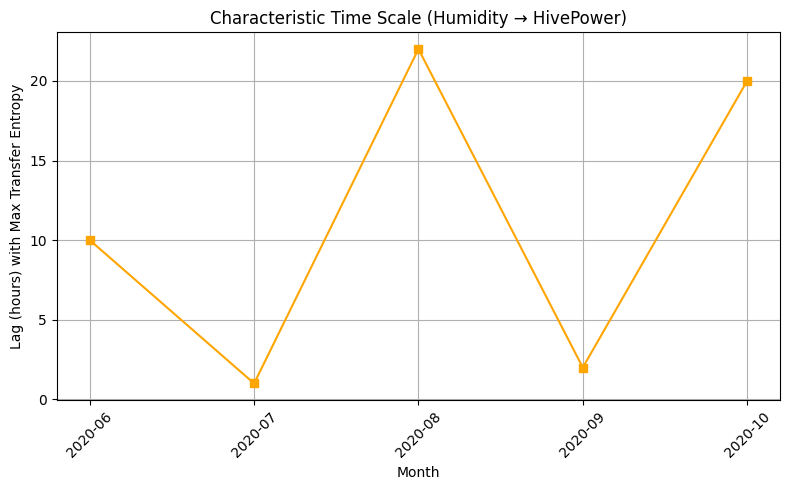

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(df_cts_humid["month"], df_cts_humid["best_lag_hours"], marker='s', color='orange')
plt.title("Characteristic Time Scale (Humidity → HivePower)")
plt.xlabel("Month")
plt.ylabel("Lag (hours) with Max Transfer Entropy")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


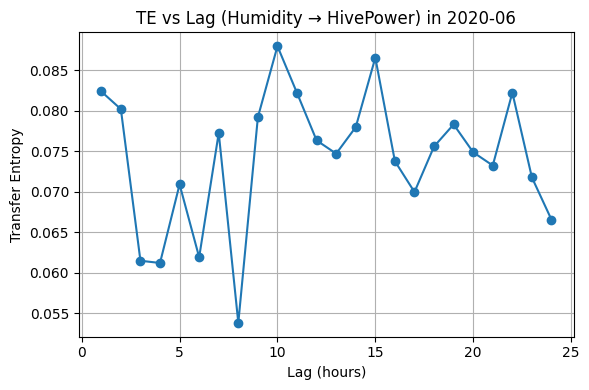

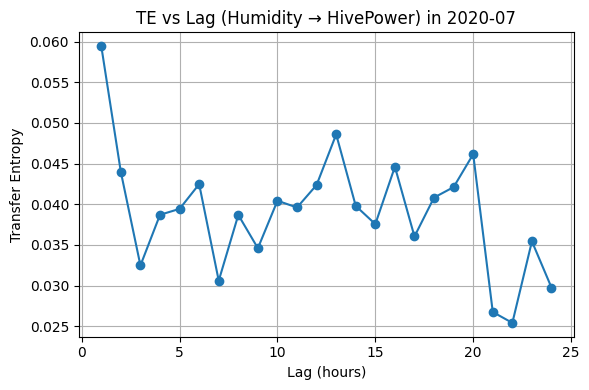

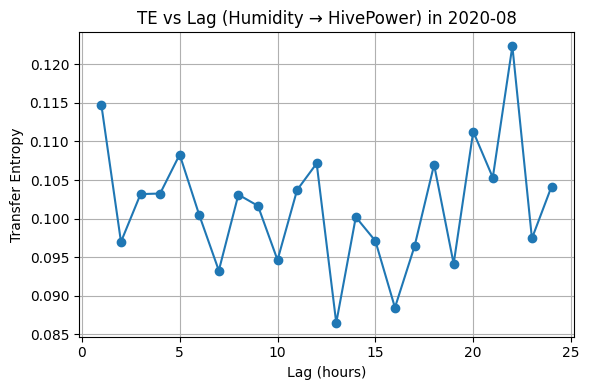

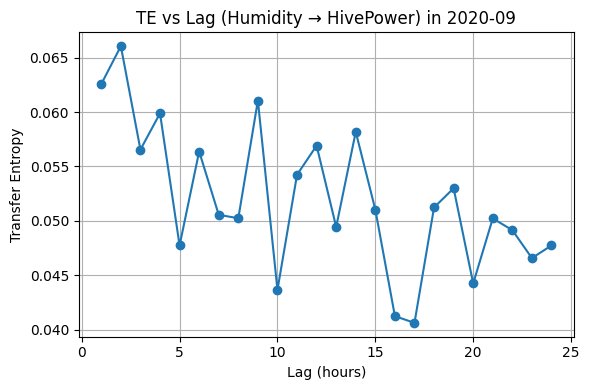

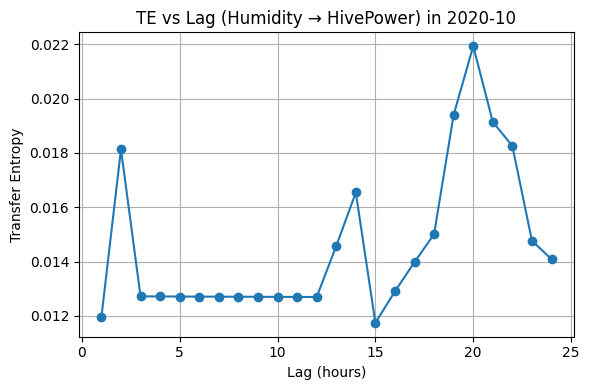

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyinform.transferentropy import transfer_entropy
from sklearn.preprocessing import KBinsDiscretizer

# ===== 离散化函数 =====
def discretize_series(series, bins=5):
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    return est.fit_transform(series.values.reshape(-1, 1)).astype(int).flatten()

# ===== 准备数据 =====
df_disc = df_hourly_clean.copy()
df_disc["humid_disc"] = discretize_series(df_disc["humidity"])
df_disc["power_disc"] = discretize_series(df_disc["hive_power"])

# ===== 设置滞后范围 =====
max_lag = 24  # 你也可以改成 36 或 48 看更大的趋势

# ===== 每月画一张 TE vs lag 曲线 =====
for month, group in df_disc.groupby("month"):
    x = group["humid_disc"].values
    y = group["power_disc"].values

    if len(x) <= max_lag + 1:
        continue

    lag_values = []
    te_values = []

    for k in range(1, max_lag + 1):
        x_lag = x[:-k]
        y_shift = y[k:]

        if len(np.unique(x_lag)) < 2 or len(np.unique(y_shift)) < 2:
            continue

        try:
            te_val = transfer_entropy(x_lag, y_shift, k=1)
            lag_values.append(k)
            te_values.append(te_val)
        except:
            continue

    # 跳过空值月份
    if not te_values:
        continue

    # 绘图
    plt.figure(figsize=(6, 4))
    plt.plot(lag_values, te_values, marker='o')
    plt.title(f"TE vs Lag (Humidity → HivePower) in {month}")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Transfer Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
